This is a showcase of implementing a linear regression model for [boston housing prices](https://www.kaggle.com/datasets/vikrishnan/boston-house-prices).

Much of what I've learned and applied in this notebook comes from Andrew NG's machine learning specialization course and other things like analyzing the importance of variables for the model I've learned while studying statistics and data processing in University.

While there are fully ready libraries to create linear regression models fast and easy, this project is meant to showcase understanding of machine learning concepts and how such libraries potentially work.

In [1]:
# Import libraries
import copy, math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm

In [2]:
#Read data from file
cols = ['CRIM', # per capita crime rate by town
           'ZN', # proportion of residential land zoned for lots over 25,000 sq.ft.
           'INDUS', # proportion of non-retail business acres per town
           'CHAS', # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
           'NOX', # nitric oxides concentration (parts per 10 million)
           'RM', # average number of rooms per dwelling
           'AGE', # proportion of owner-occupied units built prior to 1940
           'DIS', # weighted distances to five Boston employment centres
           'RAD', # index of accessibility to radial highways
           'TAX', # full-value property-tax rate per $10,000
           'PTRATIO', # pupil-teacher ratio by town
           'B', # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
           'LSTAT', # % lower status of the population
           'MEDV'] # Median value of owner-occupied homes in $1000's
data=pd.read_csv('housing.csv', header=None, delim_whitespace=True)
data.columns = cols # Add columns into the data
data.head() # Print the first rows of data to see it was imported properly

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
# Split the data into features and target sets
X = data.iloc[:, :-1] # All columns except last goes into X
y = data.iloc[:, -1] # Only select last column for y
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


         CRIM    ZN  INDUS  CHAS   NOX    RM   AGE   DIS   RAD   TAX  PTRATIO  \
CRIM     1.00 -0.20   0.41 -0.06  0.42 -0.22  0.35 -0.38  0.63  0.58     0.29   
ZN      -0.20  1.00  -0.53 -0.04 -0.52  0.31 -0.57  0.66 -0.31 -0.31    -0.39   
INDUS    0.41 -0.53   1.00  0.06  0.76 -0.39  0.64 -0.71  0.60  0.72     0.38   
CHAS    -0.06 -0.04   0.06  1.00  0.09  0.09  0.09 -0.10 -0.01 -0.04    -0.12   
NOX      0.42 -0.52   0.76  0.09  1.00 -0.30  0.73 -0.77  0.61  0.67     0.19   
RM      -0.22  0.31  -0.39  0.09 -0.30  1.00 -0.24  0.21 -0.21 -0.29    -0.36   
AGE      0.35 -0.57   0.64  0.09  0.73 -0.24  1.00 -0.75  0.46  0.51     0.26   
DIS     -0.38  0.66  -0.71 -0.10 -0.77  0.21 -0.75  1.00 -0.49 -0.53    -0.23   
RAD      0.63 -0.31   0.60 -0.01  0.61 -0.21  0.46 -0.49  1.00  0.91     0.46   
TAX      0.58 -0.31   0.72 -0.04  0.67 -0.29  0.51 -0.53  0.91  1.00     0.46   
PTRATIO  0.29 -0.39   0.38 -0.12  0.19 -0.36  0.26 -0.23  0.46  0.46     1.00   
B       -0.39  0.18  -0.36  

<Axes: >

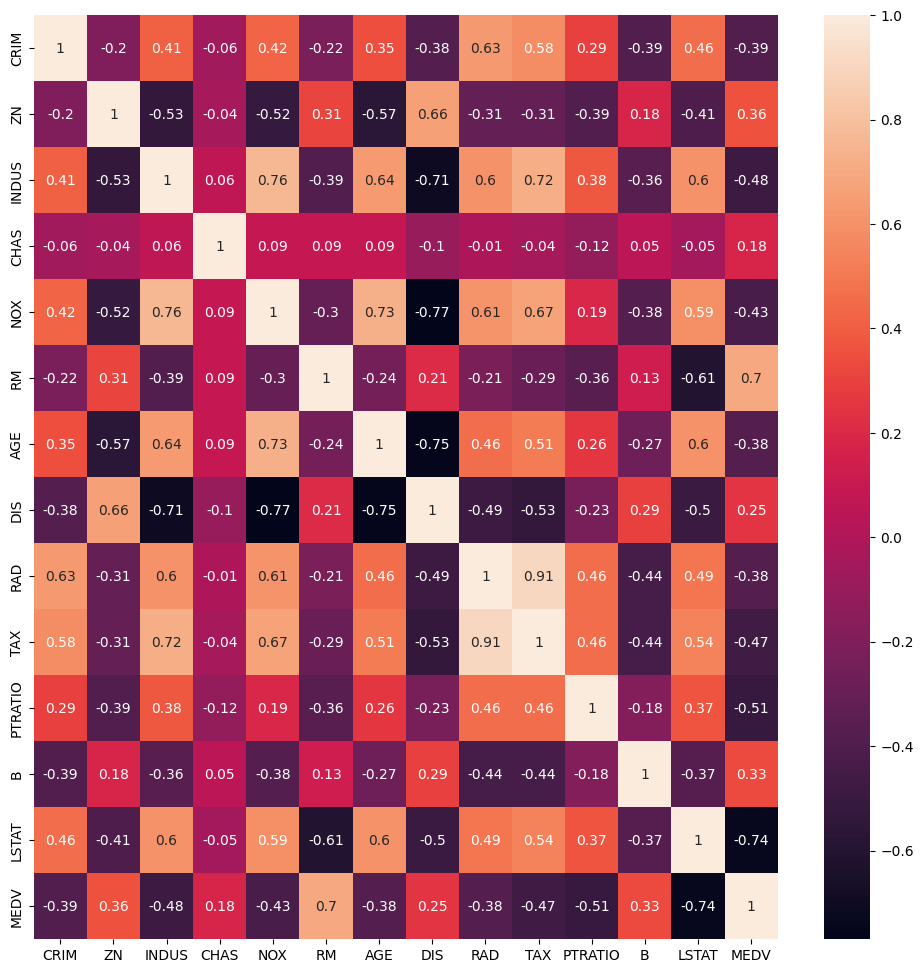

In [4]:
# Print the correlations between the features and create a heatmap for visualization
correlations = data.corr().round(2)
print(correlations)
fix, ax = plt.subplots(figsize=(12,12))
sb.heatmap(data=correlations, annot=True, ax=ax)

The heatmap tells us which variables have a high correlation. Whenever two variables highly correlate with each other, it is better to only include the other one of the two in the model.
If we assumed a treshold of 0.75, such pairs to consider could be 
- (INDUS, NOX): 0.76, 
- (NOX, DIS): -0.77, 
- (AGE, DIS): -0.75 and
- (RAD, TAX): 0.91.

Next thing to look at would be the p-values of the variables. If a variable has a p-value greater than 0.05, then that variable isn't significant enough to include in the model.

In [5]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
fit_est = est.fit()
print(fit_est.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Thu, 27 Apr 2023   Prob (F-statistic):          6.72e-135
Time:                        21:44:06   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.0

From above summary we can see the following variables with p-value > 0.05
- INDUS 0.738
- AGE 0.958

We could try removing AGE, INDUS and TAX to see how that could help our model

In [6]:
#Let's remove INDUS, AGE and TAX from the X and columns
cols_to_remove = ['INDUS', 'AGE', 'TAX']
new_X = X.drop(cols_to_remove, axis=1)
new_X.head()

,CRIM,ZN,CHAS,NOX,RM,DIS,RAD,PTRATIO,B,LSTAT
0,0.00632,18.0,0,0.538,6.575,4.0900,1,15.3,396.90,4.98
1,0.02731,0.0,0,0.469,6.421,4.9671,2,17.8,396.90,9.14
2,0.02729,0.0,0,0.469,7.185,4.9671,2,17.8,392.83,4.03
3,0.03237,0.0,0,0.458,6.998,6.0622,3,18.7,394.63,2.94
4,0.06905,0.0,0,0.458,7.147,6.0622,3,18.7,396.90,5.33


In [7]:
# Split data into training and testing sets with 70/30 partition, random state is for reproducibility
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=42)

# Print the shapes of the sets
print('X_train: ', X_train.shape, 'X_test: ', X_test.shape, 
     'y_train: ', y_train.shape, 'y_test: ', y_test.shape)

X_train:  (354, 10) X_test:  (152, 10) y_train:  (354,) y_test:  (152,)


We are going to implement the fitting of the model by ourselves by creating a gradient descent method that takes X_train and y_train as well as initial weights and constant for the model. 

The method also needs a cost-function and gradient-function as well as alpha-value to determine the amount of descending per iteration and finally a limit-value for iterations.

For variables CRIM, ZN, CHAS, RM, DIS, RAD PTRATIO, B and LSTAT we will have weights w1, w2, ..., w9 in our model as well as constant B. Also let x1, x2, ..., x9 correspond to our variable names in that order. Our model would look something like this:

$f(\mathbf{x}^{(i)}) = w1x1^{(i)}+w2x2^{(i)}+...+w9x9^{(i)}+b$ where i refers to the row in data

To find the optimal model, we will have initial values for all the weights and the constant. Then using the cost function and gradient function, we will keep iterating towards lower and lower cost model with the value alpha deciding how big the steps are each iteration.

Start with writing the compute_cost method, that returns the total cost over all examples
$cost^{(i)} = (f(\mathbf{x})^{(i)}-y^{(i)})^2$

Additionally, the total sum of cost to be returned should equal to <br>
$J(\mathbf{w}, b)= \frac{1}{2m}\sum_{m-1}^{i=0}(f(\mathbf{x})^{(i)}-y^{(i)})^2$

This method isn't actually used in the model itself (We use the partial derivation of the cost function instead), but can be later used to graph how the cost function converges during gradient descent

In [8]:
def compute_cost(X, y, w, b):
    m = X.shape[0] # Rows of X training set
    total_cost = 0.0 # Total sum of all computed costs for all rows.
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b # Using dot product for fast calculation
        total_cost += (f_wb_i-y[i])**2
    total_cost = total_cost/(2*m)
    return total_cost

Gradient descent's purpose is to take move to the lowest possible point of cost found within the dimensions of the features in the model. 

For this, the partial derivative of $\mathbf{w}$ and b are used with the size of step alpha, until $\mathbf{w}$ and b converge.

We can use the following formulas in computing gradient

$w_j = w_j-\alpha \frac{\partial}{\partial w_j}J(\mathbf{w}, b)$ for $j = 0..n-1$ and <br>
$b = b-\alpha \frac{\partial}{\partial b} J(\mathbf{w}, b)$

where n is the number of features in the model and the partial derivatives

$\frac{\partial}{\partial w_j} = \frac{1}{m}\sum_{i=0}^{m-1}(f(\mathbf{x})^{(i)}-y^{(i)})x_{j}^{(i)}$ and <br>
$\frac{\partial}{\partial \mathbf{b}} =\frac{1}{m}\sum_{i=0}^{m-1}(f(\mathbf{x})^{(i)}-y^{(i)})$

where m is the number of rows in data. 

With the two previous formulas, we can write compute_gradient function which returns the partial derivatives for $\mathbf{w}$ and b.

In [9]:
def compute_gradient(X, y, w, b):
    m,n = X.shape #m amount of data rows and n amount of features
    dj_dw = np.zeros((n,)) # Partial derivatives for weights w
    dj_db = 0. # Partial derivative for constant b
    
    for i in range(m): # For each row i in data
        err = (np.dot(X[i], w)+b)-y[i] # Difference between estimation and real value
        for j in range(n): # For each feature j in data.
            dj_dw[j] += err*X[i,j] #Sum of all rows i for weight j
        dj_db += err #Sum of all rows for constant b
    dj_dw = dj_dw/m
    dj_db = dj_db/m
    
    return dj_dw, dj_db

In [10]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    w = copy.deepcopy(w_in) # This is to avoid modifying global w in function
    b = b_in
    cost_history = [] # Visualize the steps taken as cost gets smaller
    
    for i in range(num_iters): # For every step during gradient descent
        dj_dw, dj_db = gradient_function(X, y, w, b) # Get the partial derivatives of w and b
        w = w-alpha*dj_dw # Update every w_j to take the next step
        b = b-alpha*dj_db # Same for constant b
        if i < 10000:
            cost_history.append(cost_function(X, y, w, b)) #save cost J for graphing
        
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {cost_history[-1]:8.2f} ")
    
    return w, b, cost_history # return final values and history of steps

In [11]:
# Initialize fitting parameters.
initial_w = np.zeros(X_train.shape[1]) #Initialize w1...w9 as 0
initial_b = 0.

# Numpy vectorization
np_X_train = X_train.to_numpy(dtype='float', na_value=np.nan)
np_y_train = y_train.to_numpy(dtype='float', na_value=np.nan)

# Initialize gradient descent settings
iterations = 12500 #With alpha 0.0001 cost converges at 10000 at cost 24.90
alpha = 0.00001 #If Alpha is too large, cost will not go down

w, b, cost_hist = gradient_descent(np_X_train, np_y_train, initial_w, initial_b, 
                     compute_cost, compute_gradient, alpha, iterations)
print("w,b found:", w, b)

Iteration    0: Cost    79.95 
Iteration 1250: Cost    33.62 
Iteration 2500: Cost    30.74 
Iteration 3750: Cost    28.89 
Iteration 5000: Cost    27.63 
Iteration 6250: Cost    26.70 
Iteration 7500: Cost    25.98 
Iteration 8750: Cost    25.39 
Iteration 10000: Cost    24.90 
Iteration 11250: Cost    24.90 
w,b found: [-0.1423155   0.06394286  0.05209566  0.0439104   0.77461341 -0.07523819
  0.14318096  0.53025136  0.0406928  -0.65056055] 0.0739307964064477


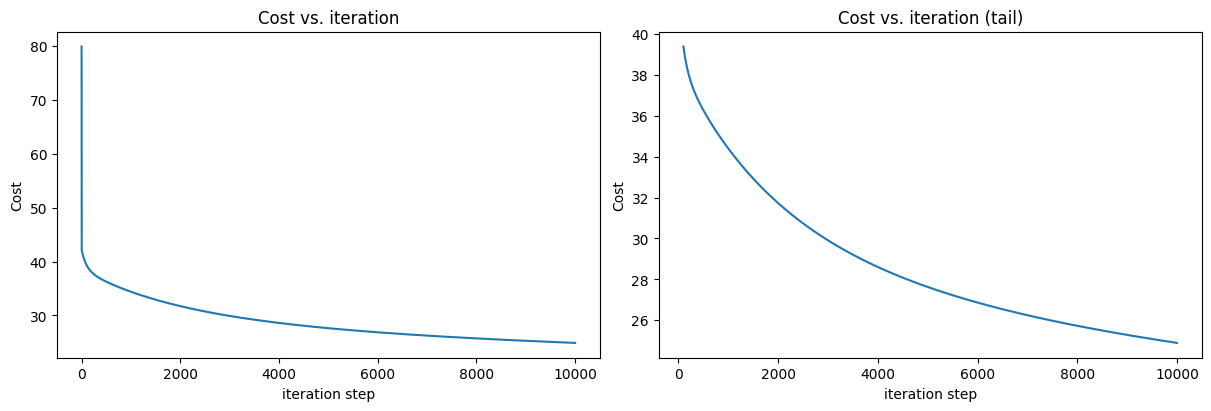

In [19]:
# plot cost versus iteration to visualize how the cost function converges
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(cost_hist)
ax2.plot(100 + np.arange(len(cost_hist[100:])), cost_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

We could now try to use the model and see how close the predictions for the first five rows of data come, using the same values and see how much the target value differs. Let's quickly display those values again.

In [20]:
display(new_X.head())
display(y.head())

,CRIM,ZN,CHAS,NOX,RM,DIS,RAD,PTRATIO,B,LSTAT
0,0.00632,18.0,0,0.538,6.575,4.0900,1,15.3,396.90,4.98
1,0.02731,0.0,0,0.469,6.421,4.9671,2,17.8,396.90,9.14
2,0.02729,0.0,0,0.469,7.185,4.9671,2,17.8,392.83,4.03
3,0.03237,0.0,0,0.458,6.998,6.0622,3,18.7,394.63,2.94
4,0.06905,0.0,0,0.458,7.147,6.0622,3,18.7,396.90,5.33


0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64

As a reminder, we deleted the variables INDUS, AGE and TAX so we pay no mind to those. Let's see how our model predicts the MEDV from these same values.

In [21]:
tests = new_X[:5].to_numpy(dtype='float', na_value=np.nan)
for i in range(5):
    prediction = np.dot(tests[i], w) + b
    real = y[i]
    print('prediction = ' + str(prediction) + ' actual value = ' + str(real))

prediction = 27.200193093975987 actual value = 24.0
prediction = 24.620400103943847 actual value = 21.6
prediction = 28.37095231175967 actual value = 34.7
prediction = 29.54526550482348 actual value = 33.4
prediction = 28.192995711374472 actual value = 36.2


Lastly, we can check the $R^2$ score for the model to have a better idea how good the model is

$R^2 = 1-\frac{\mathbf{SS}_{res}}{\mathbf{SS}_{tot}} 
= 1-\dfrac{\sum_{i=0}^{m-1}(\hat{y}_i-y_i)^2}{\sum_{i=0}^{m-1}(y_i-\bar{y})^2}$ where 

$\mathbf{SS}_{res}$ is sum of squares of residual errors and <br>
$\mathbf{SS}_{tot}$ is total sum of squares.

In [22]:
def predict(tests, w, b):
    predictions = []
    for test in tests: #Each test is an array of x-parameters
        prediction = np.dot(test, w) + b
        predictions.append(prediction)
    
    return predictions

In [23]:
# Numpy vectorization
np_X_test = X_test.to_numpy(dtype='float', na_value=np.nan)
np_y_test = y_test.to_numpy(dtype='float', na_value=np.nan)
predictions = predict(np_X_test, w, b)
mu = np.mean(np_y_test) # Mean of y
ssr = 0.0
sst = 0.0

m = np_X_test.shape[0]
for i in range(m):
    prediction = np.dot(np_X_test[i], w) + b
    ssr += (predictions[i]-np_y_test[i])**2
    sst += (np_y_test[i]-mu)**2
    
r2 = 1-(ssr/sst)
skr2 = r2_score(np_y_test, predictions) # This is used purely to assert the r2 is right
print(r2, skr2)

0.3373934808291952 0.33739348082919485


The $R^2$-score we got is only roughly 0.34, which means the current model isn't very reliable. We could try to make a better model with feature scaling, so it would be a good idea as a next step to take a look at the value ranges of the features in the model and see if they some could be scaled for better results.

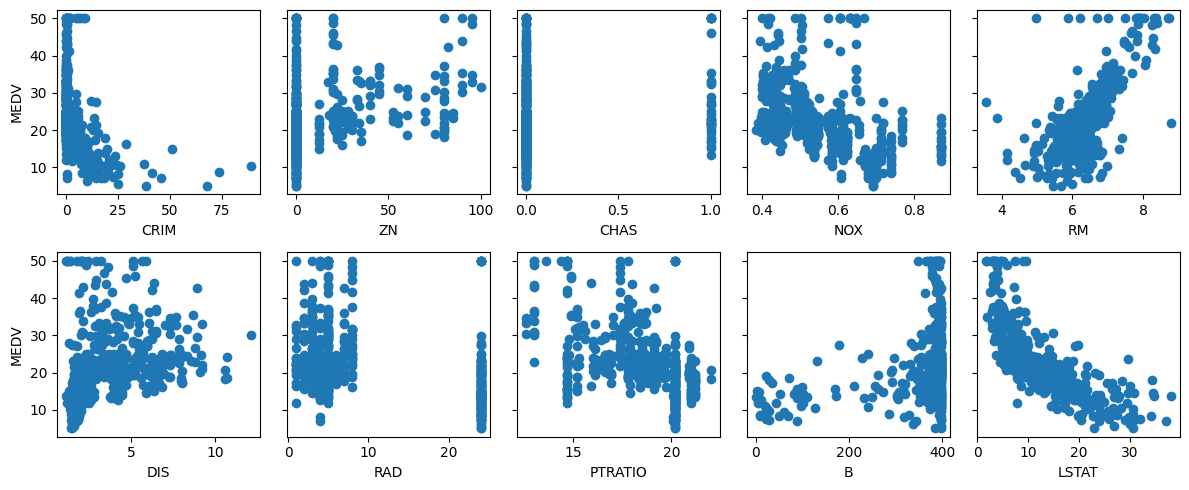

In [24]:
# Create scatter plots to visualize relationships of each feature with the target variable.
# These visualizations can later help make the model better by using feature scaling.
fig,ax=plt.subplots(2, 5, figsize=(12, 5), sharey=True)
for i in range(5):
    ax[0,i].scatter(new_X.iloc[:,i],y)
    ax[0,i].set_xlabel(new_X.columns[i])
    ax[1,i].scatter(new_X.iloc[:,i+5],y) #plotting second row
    ax[1,i].set_xlabel(new_X.columns[i+5]) 
ax[0,0].set_ylabel("MEDV")
ax[1,0].set_ylabel("MEDV")
plt.tight_layout()
plt.show()

The gradient descent moves very unevenly for these variables, because the values have very different ranges. Feature scaling could improve the model or at least help the performance of gradient descent. We could use z-score normalization to rescale each feature, which will give the features a mean of 0 and standard deviation of 1. 

Input values will be adjusted with following formula<br>
$x_j^{(i)}=\frac{x_j^{(i)}-\mu_j}{\sigma_j}$ where $j$ is the feature in the matrix $\mathbf{X}$ and $\mu_j$ is the mean of all values for feature $j$. $\sigma_j$ is standard deviation of feature $j$.

Formula for mean and standard deviation are $\mu_j=\frac{1}{m}\sum_{i=0}^{m-1}x_j^{(i)}$ and
$\sigma_j = \sqrt{\frac{1}{m}\sum_{i=0}^{m-1}(x_j^{(i)}-\mu_j)^2}$

In [25]:
def zscore_normalize(X_input):
    mu = np.mean(X_input, axis=0) # Axis 0 calculates means of columns, which are the features
    std = np.std(X_input, axis=0) # Get the standard deviations for columns, which is variance squared.
    X_norm = (X_input-mu)/std # We can scale the whole matrix at once with the n long vectors above.
    
    return (X_norm, mu, std)

In [26]:
#Print the difference with scaled features
X_norm, mu, std = zscore_normalize(np_X_train)
print(f"means = {np.array_str(mu, precision=2, suppress_small=True)}")
print(f"sigmas = {np.array_str(std, precision=2, suppress_small=True)}")
print(f"Range by column in X: {np.array_str(np.ptp(np_X_train,axis=0), precision=2, suppress_small=True)}")   
print(f"Range by column in normalized X: {np.array_str(np.ptp(X_norm,axis=0), precision=2, suppress_small=True)}")

means = [  3.47  11.4    0.07   0.56   6.33   3.77   9.44  18.28 359.7   12.42]
sigmas = [ 8.3  22.58  0.26  0.12  0.72  2.12  8.63  2.25 86.8   7.1 ]
Range by column in X: [ 88.97  95.     1.     0.49   4.92  11.    23.     9.4  396.58  36.24]
Range by column in normalized X: [10.71  4.21  3.83  4.17  6.85  5.18  2.67  4.17  4.57  5.1 ]


In [27]:
# Let's run gradient descent with the new scaled data
iterations2 = 2000 # Way less iterations needed when data is normalized
alpha2 = 0.01 # Alpha is much bigger now.
w2, b2, cost_hist = gradient_descent(X_norm, np_y_train, initial_w, initial_b, 
                     compute_cost, compute_gradient, alpha2, iterations2)
print("w,b found:", w, b)

Iteration    0: Cost   301.75 
Iteration  200: Cost    16.81 
Iteration  400: Cost    11.78 
Iteration  600: Cost    11.55 
Iteration  800: Cost    11.48 
Iteration 1000: Cost    11.44 
Iteration 1200: Cost    11.43 
Iteration 1400: Cost    11.42 
Iteration 1600: Cost    11.41 
Iteration 1800: Cost    11.41 
w,b found: [-0.1423155   0.06394286  0.05209566  0.0439104   0.77461341 -0.07523819
  0.14318096  0.53025136  0.0406928  -0.65056055] 0.0739307964064477


With the normalized features, we got both the learning rate and the cost down way more, from 24.90 to 11.41. Let's check if the r2-score got any better.

In [28]:
X_test_norm, _, _ = zscore_normalize(np_X_test)
predictions2 = predict(X_test_norm, w2, b2)
skr2 = r2_score(np_y_test, predictions2) # Check the r2 score
print(f"R2-score for model when using normalized features: {skr2}")

R2-score for model when using normalized features: 0.6651499425103821


This is significantly better than the previous score of 0.34. It is still in no way perfect, but 0.67 is somewhat acceptable R2-score for now and the learning experience has been well worth it.

Is there still something we could do to increase the model's reliability? We could try to do some feature engineering. One idea, that comes to mind is adding a new feature that is LSTAT, but squared. This is because when earlier we looked at the graphs correlating with the target value, this value correlated negatively with a bit of a curve and not a line.

In [58]:
lstat = X_norm[:, -1] #Get the feature LSTAT from data
lstat_squared = np.square(lstat) # Square it
X_norm_with_sqrt_ft = np.insert(X_norm, -1, lstat_squared, axis=1) # Create new updated array
print(X_norm.shape, X_norm_with_sqrt_ft.shape)

initial_w = np.zeros(X_norm_with_sqrt_ft.shape[1]) #Initialize weights as 0
initial_b = 0.

iterations2 = 2000 # Same as in previous fitting
alpha2 = 0.01 # Same as in previous fitting
w3, b3, cost_hist = gradient_descent(X_norm_with_sqrt_ft, np_y_train, initial_w, initial_b, 
                     compute_cost, compute_gradient, alpha2, iterations2)
print("w,b found:", w, b)

(354, 10) (354, 11)
Iteration    0: Cost   297.79 
Iteration  200: Cost    17.69 
Iteration  400: Cost    10.23 
Iteration  600: Cost     9.57 
Iteration  800: Cost     9.45 
Iteration 1000: Cost     9.41 
Iteration 1200: Cost     9.38 
Iteration 1400: Cost     9.37 
Iteration 1600: Cost     9.37 
Iteration 1800: Cost     9.36 
w,b found: [-0.1423155   0.06394286  0.05209566  0.0439104   0.77461341 -0.07523819
  0.14318096  0.53025136  0.0406928  -0.65056055] 0.0739307964064477


In [59]:
X_test_norm_with_sqrt_ft = np.insert(X_test_norm, -1, np.square(X_test_norm[:,-1]), axis=1)
print(X_test_norm.shape, X_test_norm_with_sqrt_ft.shape)

predictions3 = predict(X_test_norm_with_sqrt_ft, w3, b3)
skr2 = r2_score(np_y_test, predictions3) # Check the r2 score
print(f"R2-score for model when using normalized features: {skr2}")

(152, 10) (152, 11)
R2-score for model when using normalized features: 0.7158582564614449


We managed to up the r2-score to 0.72 from 0.65 (when rounded at two decimals). 